In [4]:
import os
import sys
import cv2
import numpy as np
import datetime
from PIL import Image
import pandas as pd 
import subprocess
sys.path.append('../')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import Video, display

import seaborn as sns
import imageio
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

In [5]:
%load_ext autoreload
%autoreload 2

In [9]:
from config import *


In [10]:
def get_video_id(game_key, play_id):
    play_id_max_len = 6
    play_id_str = str(play_id)
    play_id_len = len(play_id_str)
    game_play_id = str(game_key) + '_'+ '0' * (play_id_max_len - play_id_len) + play_id_str
    return game_play_id
    

### Links

https://www.kaggle.com/hidehisaarai1213/nfl-impact-create-tracking-animation

In [14]:
%cd ..

/home/anastasiya/Kaggle/NFL/nfl_impact_detection/nascar


In [272]:
train_video_fns = os.listdir(train_fp)
video_fn = train_video_fns[0]
train_video_fps = [train_fp + fn for fn in train_video_fns]
video_fp = train_video_fps[0]

### train_labels

In [273]:
train_labels = pd.read_csv(train_labels_fp)
train_labels = train_labels[train_labels['frame'] >= 1]

In [274]:
train_labels['video_id'] = train_labels[['gameKey', 'playID']].apply(lambda x: get_video_id(x.gameKey, x.playID), axis=1)

In [275]:
train_labels.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,video_id
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,NaN,NaN,NaN,NaN,57583_000082
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,NaN,NaN,NaN,NaN,57583_000082
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,NaN,NaN,NaN,NaN,57583_000082
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,NaN,NaN,NaN,NaN,57583_000082
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,NaN,NaN,NaN,NaN,57583_000082


In [276]:
nframes = train_labels[['video_id', 'frame']].groupby('video_id').max().reset_index().rename(columns={'frame': 'max_frame'})

In [277]:
nframes.head()

,video_id,max_frame
0,57583_000082,472
1,57584_000336,616
2,57584_002674,421
3,57586_000540,492
4,57586_001934,474


In [278]:
len(imp)

1888

### train_tracking

In [279]:
train_tracking = pd.read_csv(train_tracking_fp).sort_values(['gameKey', 'playID', 'time'])

In [280]:
len(train_tracking)

333811

In [281]:
train_tracking.query("gameKey == '57583' and playID == '82'")['time'].unique()

array(['2018-09-14T00:23:45.500Z', '2018-09-14T00:23:45.599Z',
       '2018-09-14T00:23:45.700Z', '2018-09-14T00:23:45.799Z',
       '2018-09-14T00:23:45.900Z', '2018-09-14T00:23:46.000Z',
       '2018-09-14T00:23:46.099Z', '2018-09-14T00:23:46.200Z',
       '2018-09-14T00:23:46.299Z', '2018-09-14T00:23:46.400Z',
       '2018-09-14T00:23:46.500Z', '2018-09-14T00:23:46.599Z',
       '2018-09-14T00:23:46.700Z', '2018-09-14T00:23:46.799Z',
       '2018-09-14T00:23:46.900Z', '2018-09-14T00:23:47.000Z',
       '2018-09-14T00:23:47.099Z', '2018-09-14T00:23:47.200Z',
       '2018-09-14T00:23:47.299Z', '2018-09-14T00:23:47.400Z',
       '2018-09-14T00:23:47.500Z', '2018-09-14T00:23:47.599Z',
       '2018-09-14T00:23:47.700Z', '2018-09-14T00:23:47.799Z',
       '2018-09-14T00:23:47.900Z', '2018-09-14T00:23:48.000Z',
       '2018-09-14T00:23:48.099Z', '2018-09-14T00:23:48.200Z',
       '2018-09-14T00:23:48.299Z', '2018-09-14T00:23:48.400Z',
       '2018-09-14T00:23:48.500Z', '2018-09-14T00:23:48

In [282]:
train_tracking.query("gameKey == '57583' and playID == '82' and event == 'ball_snap'")

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event
147,57583,82,H97,2018-09-14T00:24:00.200Z,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap
398,57583,82,H96,2018-09-14T00:24:00.200Z,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap
649,57583,82,H90,2018-09-14T00:24:00.200Z,35.40,31.27,0.01,0.01,0.00,283.00,217.26,ball_snap
900,57583,82,H27,2018-09-14T00:24:00.200Z,39.77,17.57,1.32,1.32,0.14,273.32,73.94,ball_snap
1151,57583,82,H36,2018-09-14T00:24:00.200Z,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap
1402,57583,82,H99,2018-09-14T00:24:00.200Z,35.32,26.25,0.00,0.00,0.00,272.45,317.96,ball_snap
1653,57583,82,H59,2018-09-14T00:24:00.200Z,37.69,21.32,1.55,1.15,0.15,273.61,258.71,ball_snap
1904,57583,82,H22,2018-09-14T00:24:00.200Z,36.09,43.24,0.00,0.00,0.00,265.05,20.14,ball_snap
2155,57583,82,H50,2018-09-14T00:24:00.200Z,39.52,27.38,0.17,0.09,0.04,268.14,339.74,ball_snap
2406,57583,82,H56,2018-09-14T00:24:00.200Z,39.34,24.56,0.02,0.02,0.01,255.43,313.31,ball_snap


In [283]:
times = train_tracking['time'].values
time_endings = set([time[-4:] for time in times])
print(time_endings)

{'900Z', '599Z', '099Z', '700Z', '400Z', '500Z', '299Z', '200Z', '799Z', '000Z'}


In [284]:
train_tracking.head()

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event
0,57583,82,H97,2018-09-14T00:23:45.500Z,38.89,28.06,0.00,0.00,0.00,261.28,222.79,NaN
251,57583,82,H96,2018-09-14T00:23:45.500Z,38.26,25.62,0.15,0.46,0.00,310.98,13.41,NaN
502,57583,82,H90,2018-09-14T00:23:45.500Z,39.63,28.01,0.00,0.00,0.00,236.64,196.94,NaN
753,57583,82,H27,2018-09-14T00:23:45.500Z,39.02,25.37,0.00,0.00,0.01,260.79,264.92,NaN
1004,57583,82,H36,2018-09-14T00:23:45.500Z,39.93,26.25,0.15,0.09,0.03,278.08,74.92,NaN


In [285]:
train_tracking['video_id'] = train_tracking[['gameKey', 'playID']].apply(lambda x: get_video_id(x.gameKey, x.playID), axis=1)

In [286]:
train_tracking.head()

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id
0,57583,82,H97,2018-09-14T00:23:45.500Z,38.89,28.06,0.00,0.00,0.00,261.28,222.79,NaN,57583_000082
251,57583,82,H96,2018-09-14T00:23:45.500Z,38.26,25.62,0.15,0.46,0.00,310.98,13.41,NaN,57583_000082
502,57583,82,H90,2018-09-14T00:23:45.500Z,39.63,28.01,0.00,0.00,0.00,236.64,196.94,NaN,57583_000082
753,57583,82,H27,2018-09-14T00:23:45.500Z,39.02,25.37,0.00,0.00,0.01,260.79,264.92,NaN,57583_000082
1004,57583,82,H36,2018-09-14T00:23:45.500Z,39.93,26.25,0.15,0.09,0.03,278.08,74.92,NaN,57583_000082


In [287]:
train_tracking['event'].unique()

array([nan, 'huddle_break_offense', 'line_set', 'man_in_motion',
       'ball_snap', 'handoff', 'tackle', 'huddle_start_offense',
       'first_contact', 'out_of_bounds', 'play_action', 'pass_forward',
       'pass_arrived', 'pass_outcome_caught', 'run', 'shift', 'touchdown',
       'penalty_flag'], dtype=object)

In [288]:
video_start = train_tracking[['video_id', 'event', 'time']][train_tracking['event'] == 'ball_snap'].rename(columns={'time': 'video_start'}).drop_duplicates()[['video_id', 'video_start']]

In [289]:
video_start.head()

,video_id,video_start
147,57583_000082,2018-09-14T00:24:00.200Z
5699,57584_000336,2018-09-16T17:17:44.500Z
11843,57584_002674,2018-09-16T19:13:40.200Z
16272,57586_000540,2018-09-16T17:25:39.900Z
22434,57586_001934,2018-09-16T18:38:20.500Z


In [290]:
train_tracking = train_tracking.merge(video_start, on=['video_id'])

In [291]:
video_ids = train_tracking['video_id'].unique()

In [292]:
date_time_str = '2018-09-14T00:23:45.500Z'
date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%dT%H:%M:%S.%fZ')
date_time_str_2 = '2018-09-14T00:23:47.200Z'
date_time_obj_2 = datetime.datetime.strptime(date_time_str_2, '%Y-%m-%dT%H:%M:%S.%fZ')

In [293]:
def get_frame(time, start):
    format_str = '%Y-%m-%dT%H:%M:%S.%fZ'
    time_obj = datetime.datetime.strptime(time, format_str)
    start_obj = datetime.datetime.strptime(start, format_str)
    
    diff = time_obj - start_obj
    frame = int(round(diff.total_seconds() * fps, 0) + 10)
    if 10 <= frame < 10000:
        return frame
    return None

In [294]:
train_tracking['tracking_frame'] = train_tracking.apply(lambda x: get_frame(x.time, x.video_start), axis=1)
train_tracking = train_tracking.dropna(subset=['tracking_frame'])
train_tracking['tracking_frame'] = train_tracking['tracking_frame'].astype(int)

In [295]:
train_tracking_new_fp = data_fp + 'cache/train_tracking_cache.csv'

In [296]:
#train_tracking.to_csv(train_tracking_new_fp)

In [297]:
train_tracking.head(100)

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame
3234,57583,82,H97,2018-09-14T00:24:00.200Z,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3235,57583,82,H96,2018-09-14T00:24:00.200Z,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3236,57583,82,H90,2018-09-14T00:24:00.200Z,35.40,31.27,0.01,0.01,0.00,283.00,217.26,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3237,57583,82,H27,2018-09-14T00:24:00.200Z,39.77,17.57,1.32,1.32,0.14,273.32,73.94,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3238,57583,82,H36,2018-09-14T00:24:00.200Z,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,57583,82,H22,2018-09-14T00:24:00.599Z,36.09,43.22,0.08,0.41,0.01,264.13,147.50,NaN,57583_000082,2018-09-14T00:24:00.200Z,34
3330,57583,82,H50,2018-09-14T00:24:00.599Z,39.42,27.39,0.31,0.86,0.04,272.71,285.22,NaN,57583_000082,2018-09-14T00:24:00.200Z,34
3331,57583,82,H56,2018-09-14T00:24:00.599Z,39.29,24.54,0.18,1.13,0.02,261.76,270.48,NaN,57583_000082,2018-09-14T00:24:00.200Z,34
3332,57583,82,H30,2018-09-14T00:24:00.599Z,47.83,27.34,3.01,1.61,0.30,282.95,19.47,NaN,57583_000082,2018-09-14T00:24:00.200Z,34


In [298]:
len(train_tracking)

149913

In [299]:
train_tracking.query("video_id == '57584_000336_Endzone.mp4'")

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame


In [300]:
def show_tracking(video_id, frame, train_tracking):
    frame_df = train_tracking.query("video_id == @video_id and tracking_frame == @frame")
    xy = frame_df[['x', 'y']].values
    xs, ys = list(zip(*xy))
    plt.plot(xs, ys, 'ro')
    plt.axis([0, 120, 0, 53.3])
    plt.show()
    show_frames(video_id, n=frame, view='Sideline')
    show_frames(video_id, n=frame, view='Endzone')

In [301]:
train_tracking['tracking_frame'].unique()

array([  10,   16,   22,   28,   34,   40,   46,   52,   58,   64,   70,
         76,   82,   88,   94,  100,  106,  112,  118,  124,  130,  136,
        142,  148,  154,  160,  166,  172,  178,  184,  190,  196,  202,
        208,  214,  220,  226,  232,  238,  244,  250,  256,  262,  268,
        274,  280,  286,  292,  298,  304,  310,  316,  322,  328,  334,
        340,  346,  352,  358,  364,  370,  376,  382,  388,  394,  400,
        406,  412,  418,  424,  430,  436,  442,  448,  453,  460,  465,
        472,  478,  483,  490,  495,  502,  508,  513,  519,  525,  531,
        537,  543,  549,  555,  561,  567,  573,  579,  585,  591,  597,
        603,  609,  615,  621,  627,  454,  477,  484,  507,  633,  466,
        471,  496,  501,  639,  645,  651,  657,  663,  669,  675,  681,
        687,  693,  699,  705,  711,  717,  723,  729,  735,  514,  526,
        538,  544,  556,  568,  741,  747,  753,  759,  765,  771,  777,
        783,  789,  795,  801,  807,  813,  819,  8

In [302]:
#show_tracking('57586_001934', 208, train_tracking)

# Join train labels and train traking

In [303]:
train_tracking.head()

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame
3234,57583,82,H97,2018-09-14T00:24:00.200Z,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3235,57583,82,H96,2018-09-14T00:24:00.200Z,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3236,57583,82,H90,2018-09-14T00:24:00.200Z,35.40,31.27,0.01,0.01,0.00,283.00,217.26,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3237,57583,82,H27,2018-09-14T00:24:00.200Z,39.77,17.57,1.32,1.32,0.14,273.32,73.94,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3238,57583,82,H36,2018-09-14T00:24:00.200Z,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10


In [304]:
train_tracking = train_tracking.merge(nframes, on=['video_id'])

In [305]:
train_tracking.head()

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame,max_frame
0,57583,82,H97,2018-09-14T00:24:00.200Z,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
1,57583,82,H96,2018-09-14T00:24:00.200Z,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
2,57583,82,H90,2018-09-14T00:24:00.200Z,35.40,31.27,0.01,0.01,0.00,283.00,217.26,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
3,57583,82,H27,2018-09-14T00:24:00.200Z,39.77,17.57,1.32,1.32,0.14,273.32,73.94,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
4,57583,82,H36,2018-09-14T00:24:00.200Z,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472


In [306]:
train_tracking = train_tracking[train_tracking['tracking_frame'] <= train_tracking['max_frame']]

In [307]:
train_tracking.head()

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame,max_frame
0,57583,82,H97,2018-09-14T00:24:00.200Z,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
1,57583,82,H96,2018-09-14T00:24:00.200Z,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
2,57583,82,H90,2018-09-14T00:24:00.200Z,35.40,31.27,0.01,0.01,0.00,283.00,217.26,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
3,57583,82,H27,2018-09-14T00:24:00.200Z,39.77,17.57,1.32,1.32,0.14,273.32,73.94,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472
4,57583,82,H36,2018-09-14T00:24:00.200Z,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10,472


In [308]:
len(train_tracking)

91316

In [309]:
train_tracking['event'].value_counts()

ball_snap              1320
handoff                1232
tackle                 1210
first_contact          1166
out_of_bounds            66
play_action              44
pass_forward             44
run                      44
touchdown                44
pass_arrived             44
pass_outcome_caught      44
penalty_flag             22
Name: event, dtype: int64

In [310]:
train_tracking.drop_duplicates(['video_id', 'event'])['event'].value_counts()

ball_snap              60
handoff                56
tackle                 55
first_contact          53
out_of_bounds           3
play_action             2
touchdown               2
run                     2
pass_outcome_caught     2
pass_forward            2
pass_arrived            2
penalty_flag            1
Name: event, dtype: int64

In [311]:
train_tracking[train_tracking['event']== 'first_contact']['tracking_frame'].value_counts()

154    154
166    132
184     88
208     88
172     66
226     66
190     66
160     44
130     44
178     44
136     44
202     44
214     44
142     22
118     22
112     22
124     22
376     22
148     22
352     22
196     22
238     22
244     22
70      22
Name: tracking_frame, dtype: int64

In [312]:
train_tracking[train_tracking['event']== 'handoff'].drop_duplicates('video_id')

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame,max_frame
330,57583,82,H97,2018-09-14T00:24:01.700Z,34.64,28.37,0.56,1.77,0.06,238.90,214.72,handoff,57583_000082,2018-09-14T00:24:00.200Z,100,472
2552,57584,336,H2,2018-09-16T17:17:45.700Z,47.66,22.93,3.71,4.88,0.37,288.01,279.03,handoff,57584_000336,2018-09-16T17:17:44.500Z,82,616
4835,57584,2674,H2,2018-09-16T19:13:41.400Z,62.72,30.58,3.60,4.27,0.36,116.65,101.84,handoff,57584_002674,2018-09-16T19:13:40.200Z,82,421
6111,57586,540,H96,2018-09-16T17:25:41.299Z,88.71,22.15,2.69,1.60,0.26,291.64,0.90,handoff,57586_000540,2018-09-16T17:25:39.900Z,94,492
8531,57586,1934,H52,2018-09-16T18:38:21.799Z,76.83,33.23,2.65,3.29,0.27,129.70,171.63,handoff,57586_001934,2018-09-16T18:38:20.500Z,88,474
13612,57594,923,H15,2018-09-16T20:39:19.099Z,57.00,44.67,5.26,1.55,0.52,293.02,302.44,handoff,57594_000923,2018-09-16T20:39:17.900Z,82,509
15592,57596,2686,H42,2018-09-16T22:28:18.299Z,31.63,30.83,3.68,0.18,0.36,148.11,148.92,handoff,57596_002686,2018-09-16T22:28:17.200Z,76,453
18320,57597,658,H77,2018-09-17T00:52:42.900Z,85.54,19.04,1.35,0.27,0.13,206.55,196.63,handoff,57597_000658,2018-09-17T00:52:41.599Z,88,549
26194,57676,3572,H1,2018-10-28T19:47:13.599Z,58.74,23.38,4.64,1.94,0.46,125.34,108.93,handoff,57676_003572,2018-10-28T19:47:12.200Z,94,322
27778,57679,3316,H26,2018-10-28T19:39:57.099Z,61.43,21.84,2.39,1.16,0.24,48.42,347.10,handoff,57679_003316,2018-10-28T19:39:55.799Z,88,336


In [313]:
train_tracking[train_tracking['event']== 'tackle'].drop_duplicates('video_id')

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame,max_frame
880,57583,82,H97,2018-09-14T00:24:04.200Z,36.68,20.26,4.36,1.50,0.41,193.12,167.93,tackle,57583_000082,2018-09-14T00:24:00.200Z,250,472
5407,57584,2674,H2,2018-09-16T19:13:44.000Z,64.65,20.96,3.47,1.26,0.35,232.57,209.75,tackle,57584_002674,2018-09-16T19:13:40.200Z,238,421
7211,57586,540,H96,2018-09-16T17:25:46.299Z,89.04,22.23,1.00,0.23,0.10,65.13,207.46,tackle,57586_000540,2018-09-16T17:25:39.900Z,394,492
9587,57586,1934,H52,2018-09-16T18:38:26.599Z,67.95,29.89,0.87,0.47,0.09,93.77,89.77,tackle,57586_001934,2018-09-16T18:38:20.500Z,376,474
14558,57594,923,H15,2018-09-16T20:39:23.400Z,51.32,41.64,2.99,1.16,0.31,118.66,114.41,tackle,57594_000923,2018-09-16T20:39:17.900Z,340,509
16626,57596,2686,H42,2018-09-16T22:28:23.000Z,24.17,25.71,3.21,1.26,0.33,282.27,284.27,tackle,57596_002686,2018-09-16T22:28:17.200Z,358,453
19398,57597,658,H77,2018-09-17T00:52:47.799Z,85.01,10.73,1.09,0.98,0.09,353.75,5.32,tackle,57597_000658,2018-09-17T00:52:41.599Z,382,549
22060,57597,1242,H50,2018-09-17T01:13:44.599Z,63.59,22.26,0.81,1.11,0.07,175.80,211.67,tackle,57597_001242,2018-09-17T01:13:42.200Z,154,394
26964,57676,3572,H1,2018-10-28T19:47:17.099Z,61.94,12.00,1.71,0.94,0.18,254.00,199.16,tackle,57676_003572,2018-10-28T19:47:12.200Z,304,322
28350,57679,3316,H26,2018-10-28T19:39:59.700Z,61.26,26.12,0.51,1.06,0.05,53.33,275.83,tackle,57679_003316,2018-10-28T19:39:55.799Z,244,336


In [314]:
train_tracking[train_tracking['event']== 'first_contact'].drop_duplicates('video_id')

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame,max_frame
2904,57584,336,H2,2018-09-16T17:17:47.299Z,44.90,29.12,4.90,2.75,0.49,66.15,12.73,first_contact,57584_000336,2018-09-16T17:17:44.500Z,178,616
5231,57584,2674,H2,2018-09-16T19:13:43.200Z,65.73,23.76,4.20,2.42,0.43,243.44,190.66,first_contact,57584_002674,2018-09-16T19:13:40.200Z,190,421
6639,57586,540,H96,2018-09-16T17:25:43.700Z,88.83,24.48,0.71,1.59,0.05,38.08,339.15,first_contact,57586_000540,2018-09-16T17:25:39.900Z,238,492
8773,57586,1934,H52,2018-09-16T18:38:22.900Z,74.62,31.64,3.93,1.98,0.38,172.64,250.96,first_contact,57586_001934,2018-09-16T18:38:20.500Z,154,474
12161,57586,4152,H52,2018-09-16T20:19:29.400Z,86.57,38.18,3.60,1.98,0.36,325.04,308.34,first_contact,57586_004152,2018-09-16T20:19:23.700Z,352,515
13898,57594,923,H15,2018-09-16T20:39:20.400Z,51.21,46.74,3.83,2.15,0.39,249.38,272.20,first_contact,57594_000923,2018-09-16T20:39:17.900Z,160,509
18672,57597,658,H77,2018-09-17T00:52:44.500Z,84.91,14.78,4.09,0.48,0.43,168.98,181.95,first_contact,57597_000658,2018-09-17T00:52:41.599Z,184,549
21752,57597,1242,H50,2018-09-17T01:13:43.200Z,62.41,23.64,3.11,0.92,0.31,142.67,101.96,first_contact,57597_001242,2018-09-17T01:13:42.200Z,70,394
26480,57676,3572,H1,2018-10-28T19:47:14.900Z,62.41,18.68,4.48,2.60,0.45,236.51,168.78,first_contact,57676_003572,2018-10-28T19:47:12.200Z,172,322
28020,57679,3316,H26,2018-10-28T19:39:58.200Z,61.29,24.57,2.97,0.60,0.29,29.01,3.61,first_contact,57679_003316,2018-10-28T19:39:55.799Z,154,336


In [315]:
tackle = train_tracking[train_tracking['event']== 'tackle'].drop_duplicates('video_id')[['video_id', 'tracking_frame']].rename(columns={'tracking_frame': 'tackle_frame'})
handoff = train_tracking[train_tracking['event']== 'handoff'].drop_duplicates('video_id')[['video_id', 'tracking_frame']].rename(columns={'tracking_frame': 'handof_frame'})
fc = train_tracking[train_tracking['event']== 'first_contact'].drop_duplicates('video_id')[['video_id', 'tracking_frame']].rename(columns={'tracking_frame': 'fc_frame'})


In [316]:
train_labels = train_labels.merge(tackle, on='video_id', how = 'left')
train_labels = train_labels.merge(handoff, on='video_id', how = 'left')
train_labels = train_labels.merge(fc, on='video_id', how = 'left')

In [317]:
train_labels.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,video_id,tackle_frame,handof_frame,fc_frame
0,57583,82,Endzone,57583_000082_Endzone.mp4,1,H30,629,19,40,24,NaN,NaN,NaN,NaN,57583_000082,250.0,100.0,NaN
1,57583,82,Endzone,57583_000082_Endzone.mp4,1,V72,443,22,344,16,NaN,NaN,NaN,NaN,57583_000082,250.0,100.0,NaN
2,57583,82,Endzone,57583_000082_Endzone.mp4,1,V86,871,21,359,17,NaN,NaN,NaN,NaN,57583_000082,250.0,100.0,NaN
3,57583,82,Endzone,57583_000082_Endzone.mp4,1,V74,771,19,345,15,NaN,NaN,NaN,NaN,57583_000082,250.0,100.0,NaN
4,57583,82,Endzone,57583_000082_Endzone.mp4,1,V34,549,26,461,20,NaN,NaN,NaN,NaN,57583_000082,250.0,100.0,NaN


In [318]:
display(Video(data=video_fp + '57584_000336_Endzone.mp4', embed=True))

In [319]:
train_tracking[train_tracking['event']== 'tackle']['tracking_frame'].value_counts()

298    110
256     88
250     66
244     66
238     66
358     66
292     66
304     44
274     44
280     44
286     44
232     44
340     44
208     44
382     44
328     44
226     22
214     22
184     22
448     22
262     22
268     22
412     22
310     22
352     22
364     22
376     22
394     22
154     22
Name: tracking_frame, dtype: int64

In [320]:
frame2tacklecount = train_tracking[train_tracking['event']== 'tackle']['tracking_frame'].value_counts().reset_index()
frame2tacklecount = dict(zip(frame2tacklecount['index'], frame2tacklecount['tracking_frame']//22))
tackle_frames = list(frame2tacklecount.keys())

In [321]:
frame2handoffcount = train_tracking[train_tracking['event']== 'handoff']['tracking_frame'].value_counts().reset_index()
frame2handoffcount = dict(zip(frame2handoffcount['index'], frame2handoffcount['tracking_frame']//22))
handoff_frames = list(frame2handoffcount.keys())

In [322]:
frame2fccount = train_tracking[train_tracking['event']== 'first_contact']['tracking_frame'].value_counts().reset_index()
frame2fccount = dict(zip(frame2fccount['index'], frame2fccount['tracking_frame']//22))
tackle_frames = list(frame2fccount.keys())

In [323]:
frame2handoffcount

{88: 17, 82: 17, 94: 11, 100: 5, 76: 3, 106: 2, 70: 1}

In [324]:
frame2fccount

{154: 7,
 166: 6,
 184: 4,
 208: 4,
 172: 3,
 226: 3,
 190: 3,
 160: 2,
 130: 2,
 178: 2,
 136: 2,
 202: 2,
 214: 2,
 142: 1,
 118: 1,
 112: 1,
 124: 1,
 376: 1,
 148: 1,
 352: 1,
 196: 1,
 238: 1,
 244: 1,
 70: 1}

In [325]:
frame2tacklecount

{298: 5,
 256: 4,
 250: 3,
 244: 3,
 238: 3,
 358: 3,
 292: 3,
 304: 2,
 274: 2,
 280: 2,
 286: 2,
 232: 2,
 340: 2,
 208: 2,
 382: 2,
 328: 2,
 226: 1,
 214: 1,
 184: 1,
 448: 1,
 262: 1,
 268: 1,
 412: 1,
 310: 1,
 352: 1,
 364: 1,
 376: 1,
 394: 1,
 154: 1}

In [326]:
train_tracking[train_tracking['event']== 'handoff']['tracking_frame'].value_counts()

88     374
82     374
94     242
100    110
76      66
106     44
70      22
Name: tracking_frame, dtype: int64

# Event correlations

In [327]:
imp = train_labels.query("impact == 1 and visibility > 0 and confidence > 1")

In [328]:
df = train_labels

In [329]:
len(imp)

1888

In [330]:
len(df)

983884

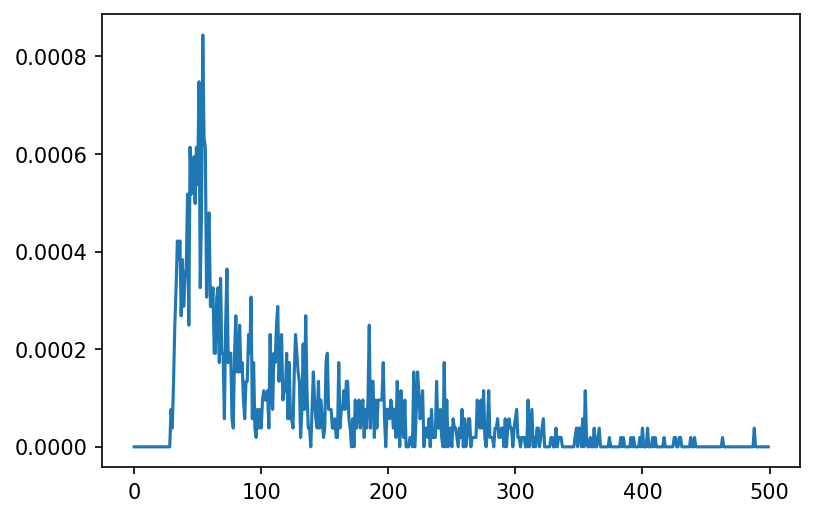

In [331]:
def plot_impact_freq_per_frame(df):
    x = []
    y = []
    for frame in range(0, 500):
        x.append(frame)
        y.append(len(imp[imp['frame'] == frame])/len(df[['video', 'frame']].drop_duplicates()))
    plt.plot(x, y)
plot_impact_freq_per_frame(train_labels)

In [538]:
def calculate_correlations(counter, window=20, event='tackle'):
    total_impacts = 0
    total_counts = 0
    left = 0 #window
    right = window + 1 #window + 1
    for frame, count in counter.items():
        imp_frame = imp[imp['frame'].isin(list(range(frame - left, frame + right)))]
        df_frame = df[df['frame'].isin(list(range(frame - left, frame + right)))].drop_duplicates(['video', 'frame'])
        total_impacts += len(imp_frame) * count
        total_counts += count * len(df_frame)
        
    print(total_impacts/total_counts/2 / (right + left))
    
    
    total_impacts = 0
    total_counts = 0
    for frame, count in counter.items():
        imp_frame = imp[(imp['frame'].isin(list(range(frame - left, frame + right ))) )&( imp[f'{event}_frame'] == frame)]
        df_frame = df[(df['frame'].isin(list(range(frame - left, frame + right ))) )&( df[f'{event}_frame'] == frame)].drop_duplicates(['video', 'frame'])
        total_impacts += len(imp_frame)
        total_counts += len(df_frame)
        
    print(total_impacts/total_counts/2 / (right + left))

In [539]:
df.columns

Index(['gameKey', 'playID', 'view', 'video', 'frame', 'label', 'left', 'width',
       'top', 'height', 'impact', 'impactType', 'confidence', 'visibility',
       'video_id', 'tackle_frame', 'handof_frame', 'fc_frame'],
      dtype='object')

In [540]:
imp.columns

Index(['gameKey', 'playID', 'view', 'video', 'frame', 'label', 'left', 'width',
       'top', 'height', 'impact', 'impactType', 'confidence', 'visibility',
       'video_id', 'tackle_frame', 'handof_frame', 'fc_frame'],
      dtype='object')

In [543]:
calculate_correlations(frame2tacklecount, event='tackle', window=10)

0.0006432246998284735
0.0008640120210368144


In [545]:
calculate_correlations(frame2handoffcount, event='handof', window=30)

0.0009154650413755512
0.0009337371785342649


In [535]:
calculate_correlations(frame2fccount, event='fc', window=3)

0.005001584660486491
0.012382075471698114


In [546]:
imp_fc = imp[abs(imp['frame'] - imp['tackle_frame'] ) <= 10]

In [510]:
imp_fc = imp[abs(imp['frame'] - 150 ) <= 10]

In [547]:
imp['fc_frame'].unique()

array([ nan, 178., 190., 238., 154., 352., 166., 160., 184.,  70., 172.,
       208., 112., 202., 226., 142., 214., 118., 148., 196., 376., 130.,
       244., 124., 136.])

In [548]:
len(imp)

1888

In [549]:
len(imp_fc)

45

In [550]:
len(imp_fc['video'].unique())

34

In [551]:
len(imp[~imp['tackle_frame'].isna()]['video'].unique())

110

# How impacts look on tracking data

In [161]:
impacts = train_labels.query("impact == 1 and visibility > 0 and confidence > 1 and impactType == 'Helmet'")

In [162]:
impacts.head()

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,video_id
746,57583,82,Endzone,57583_000082_Endzone.mp4,38,H99,582,21,311,27,1.0,Helmet,2.0,2.0,57583_000082
754,57583,82,Endzone,57583_000082_Endzone.mp4,38,V68,562,18,313,15,1.0,Helmet,2.0,2.0,57583_000082
967,57583,82,Endzone,57583_000082_Endzone.mp4,49,H97,425,15,311,20,1.0,Helmet,3.0,3.0,57583_000082
969,57583,82,Endzone,57583_000082_Endzone.mp4,49,V72,434,18,316,15,1.0,Helmet,3.0,3.0,57583_000082
1149,57583,82,Endzone,57583_000082_Endzone.mp4,58,H90,238,18,299,31,1.0,Helmet,3.0,3.0,57583_000082


In [163]:
train_tracking.head()

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame
3234,57583,82,H97,2018-09-14T00:24:00.200Z,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3235,57583,82,H96,2018-09-14T00:24:00.200Z,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3236,57583,82,H90,2018-09-14T00:24:00.200Z,35.40,31.27,0.01,0.01,0.00,283.00,217.26,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3237,57583,82,H27,2018-09-14T00:24:00.200Z,39.77,17.57,1.32,1.32,0.14,273.32,73.94,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3238,57583,82,H36,2018-09-14T00:24:00.200Z,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10


In [ ]:
count = 0
for i, row in impacts.iterrows():
 
    impact_frame = row['frame']
    video_id = row['video_id']
    player = row['label']
    
    other_impact = 

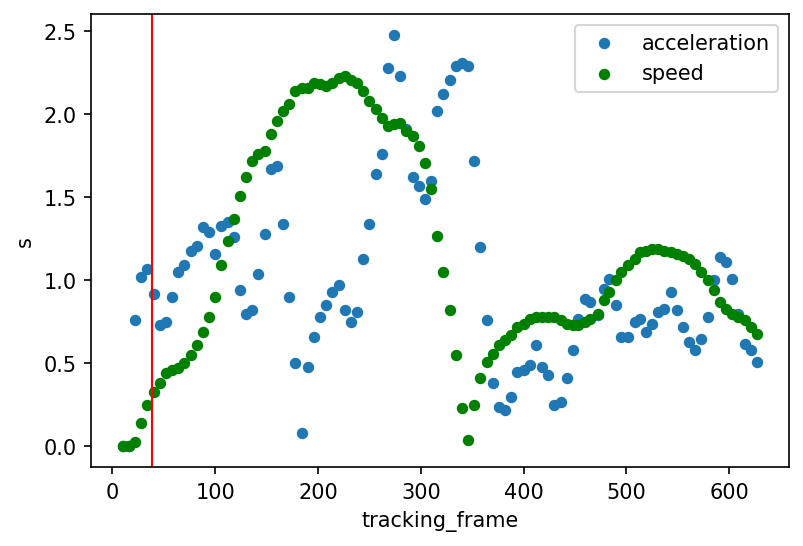

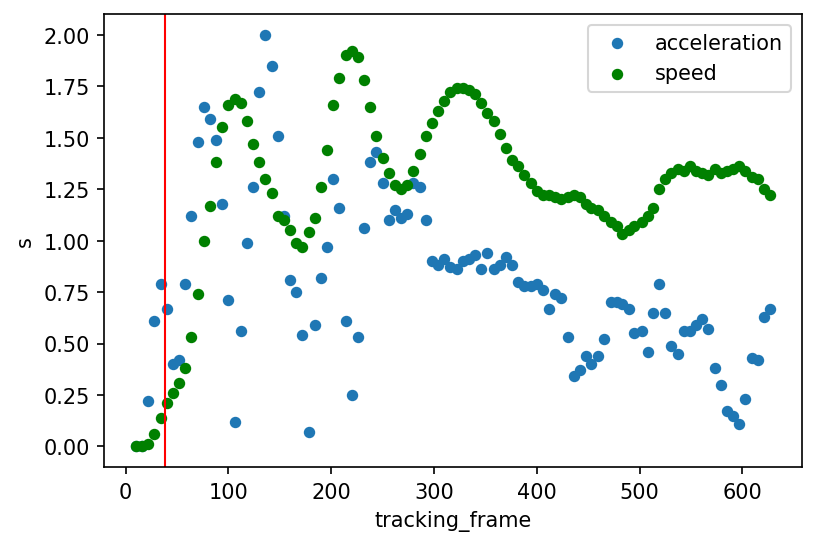

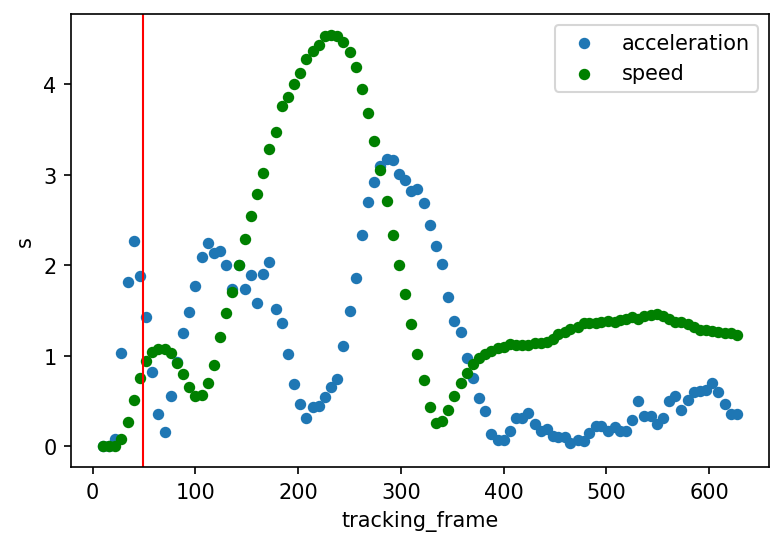

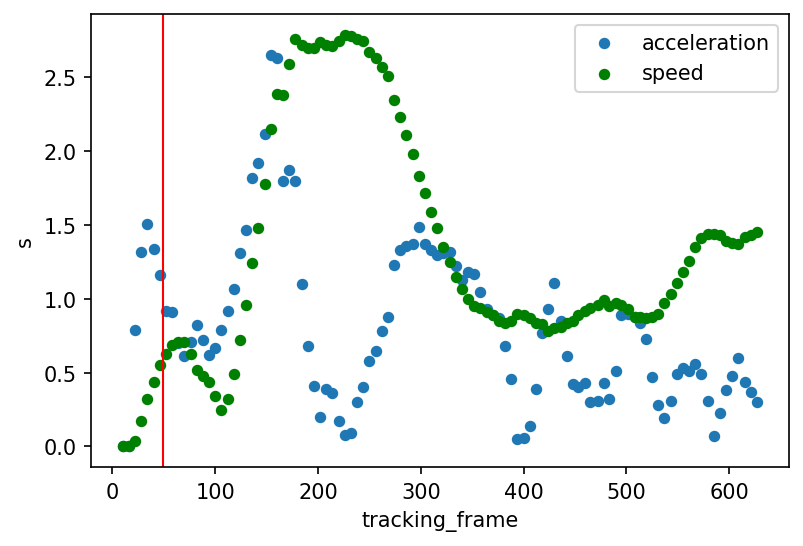

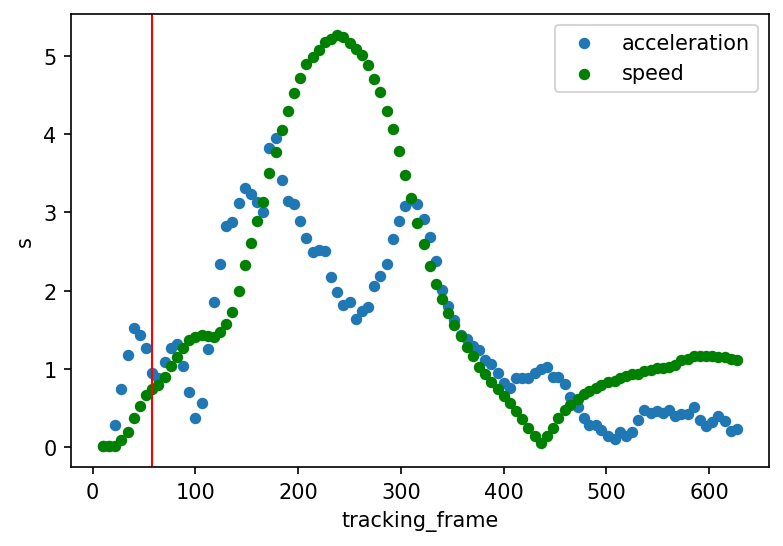

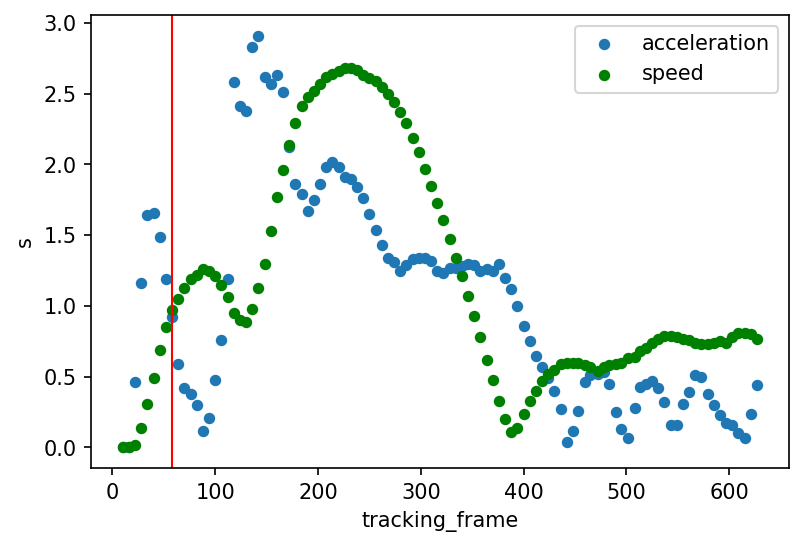

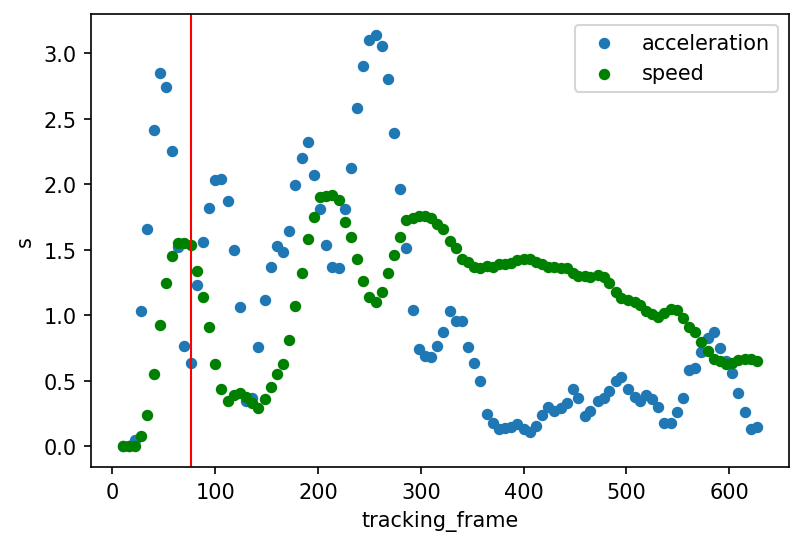

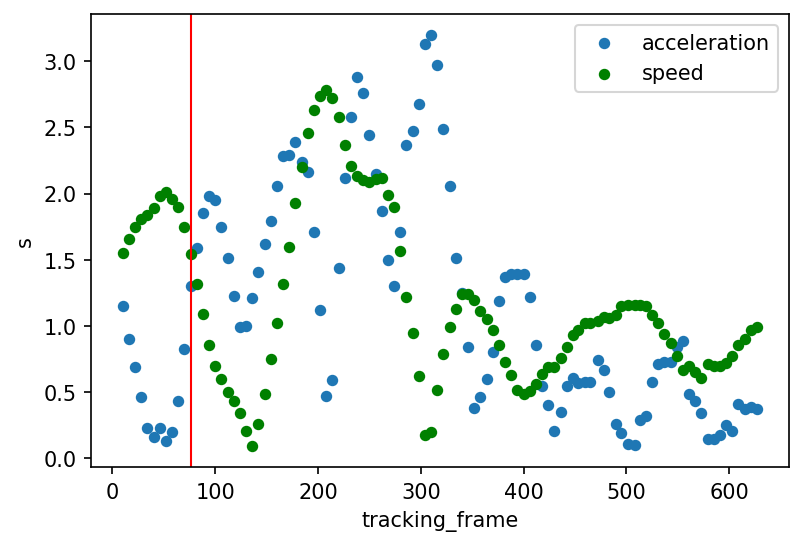

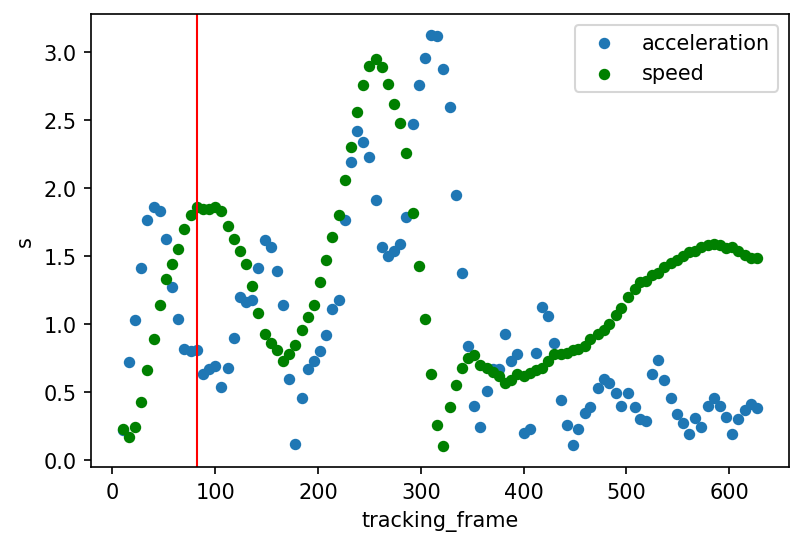

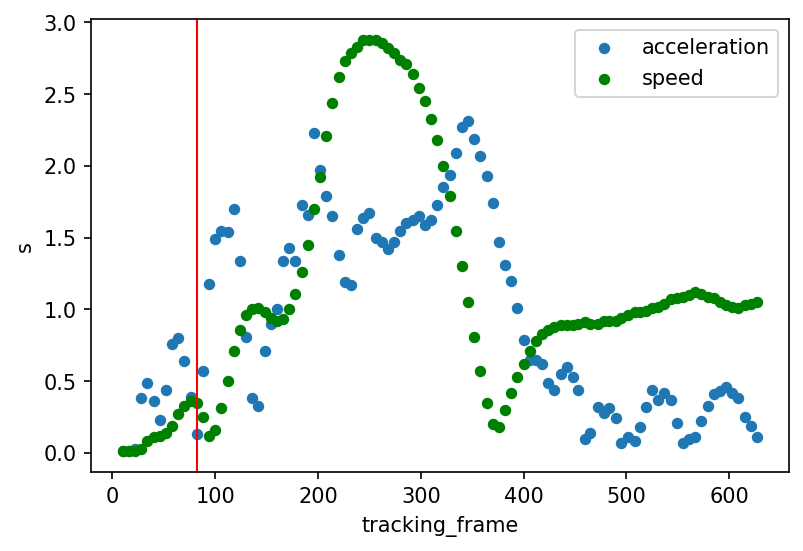

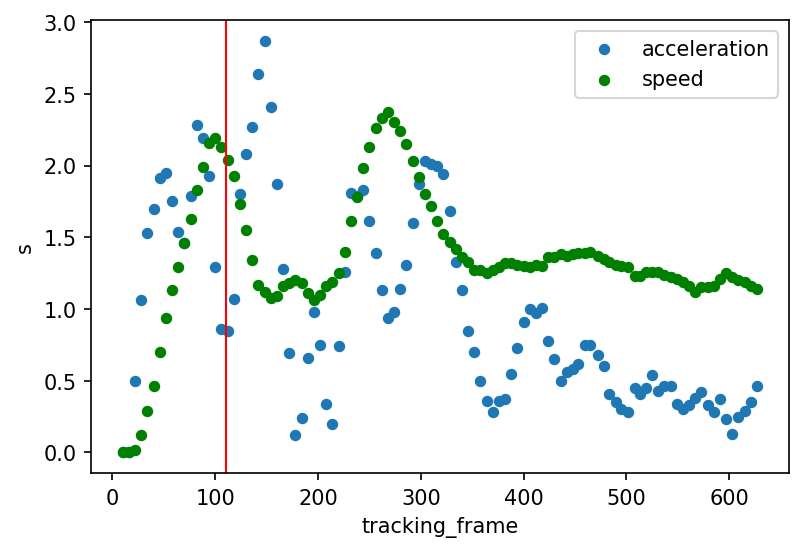

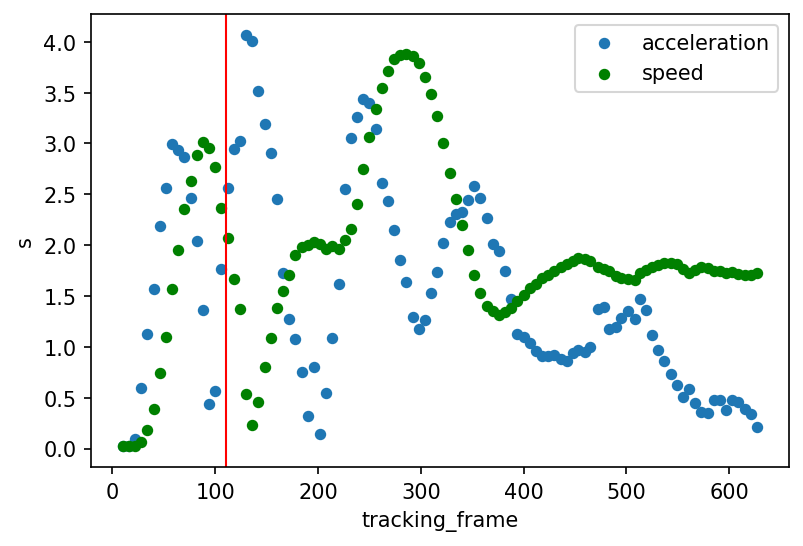

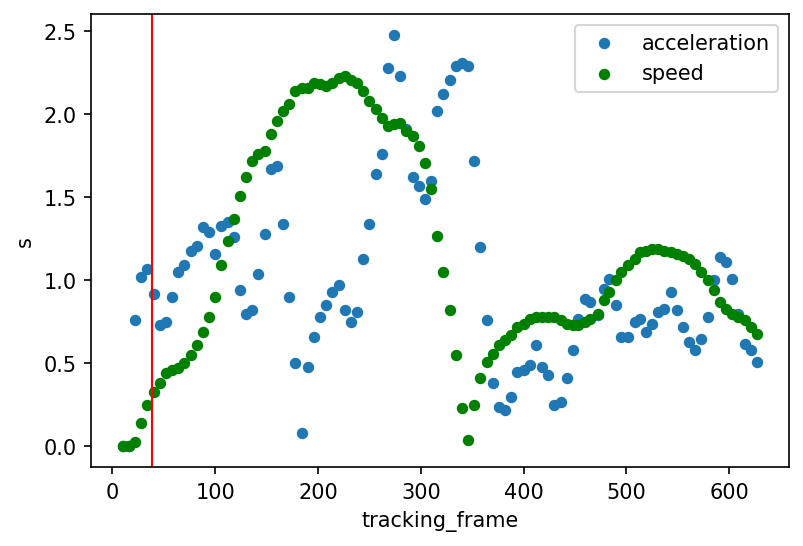

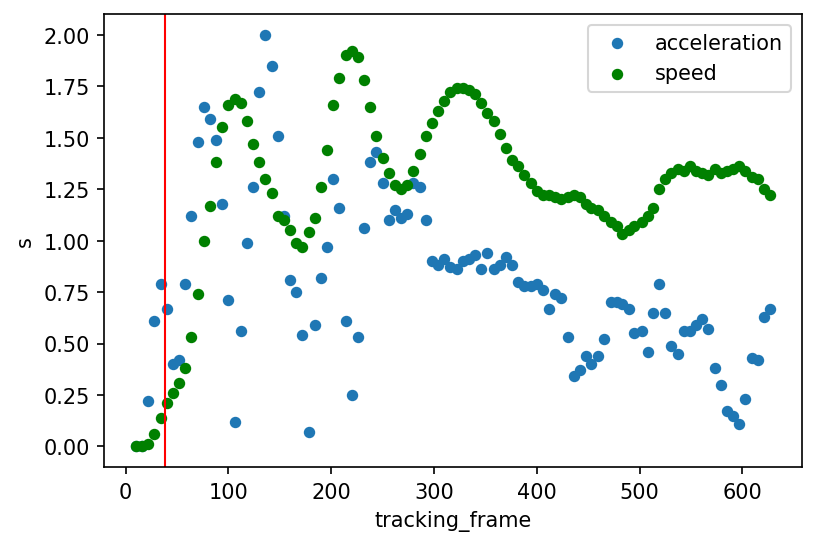

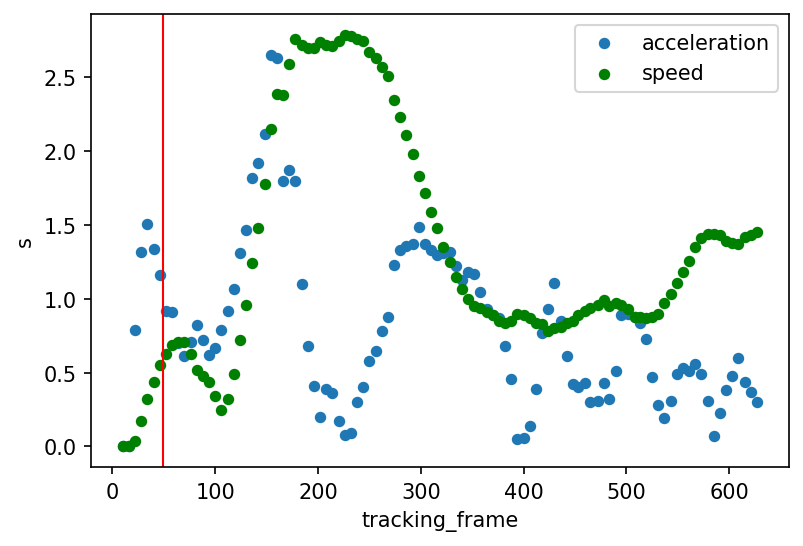

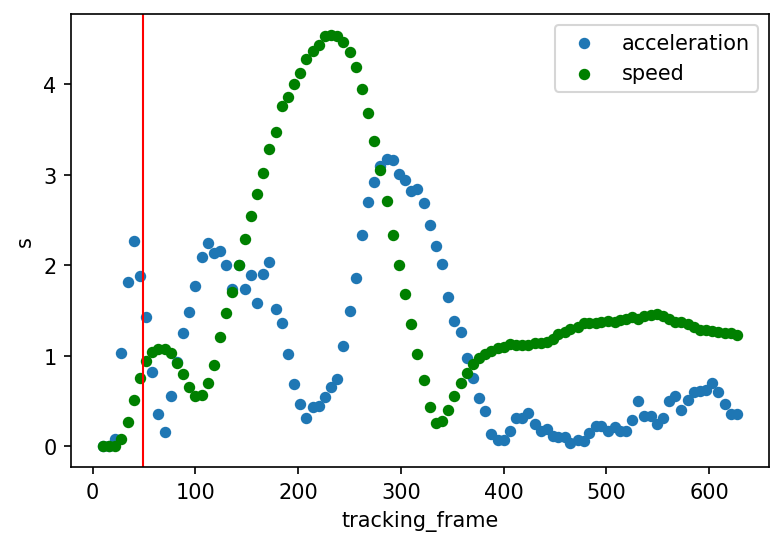

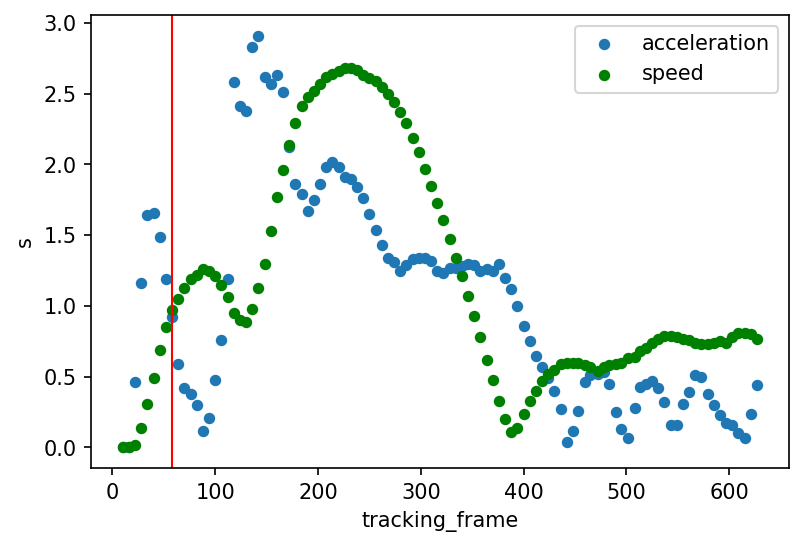

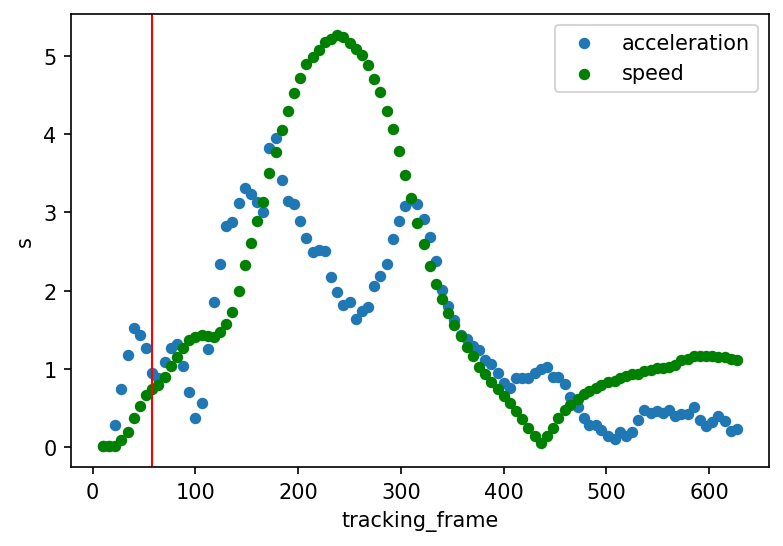

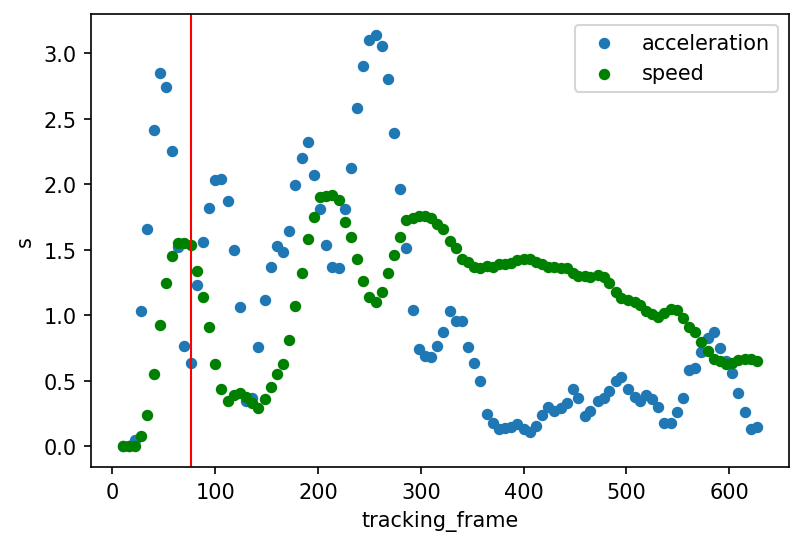

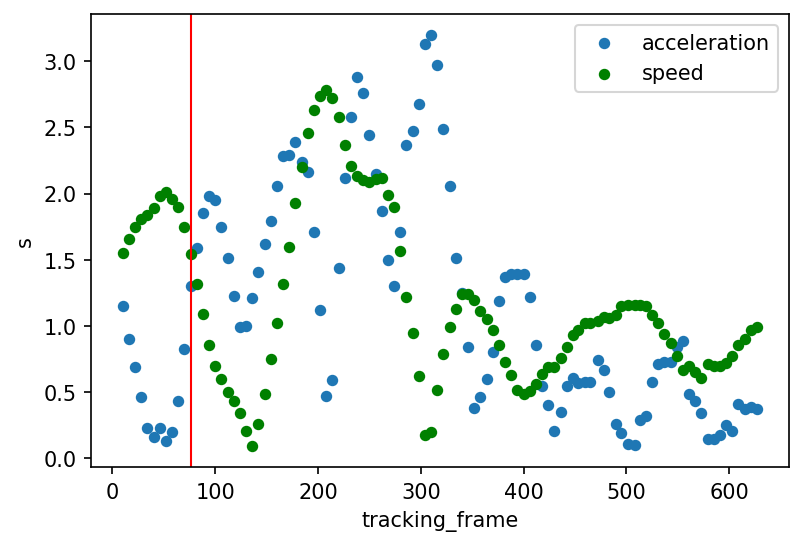

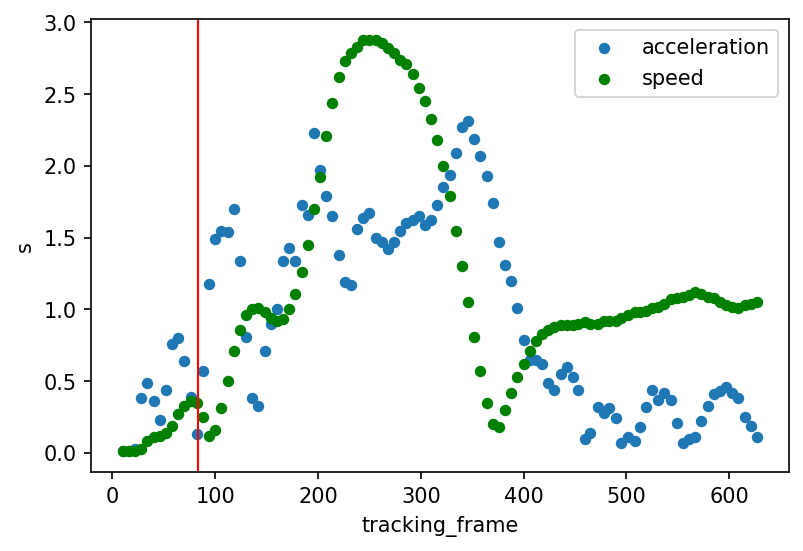

In [169]:
count = 0
for i, row in impacts.iterrows():
 
    impact_frame = row['frame']
    video_id = row['video_id']
    player = row['label']
    ax = train_tracking.query("video_id==@video_id and player==@player").plot(x='tracking_frame', y='a', kind='scatter', label='acceleration')
    train_tracking.query("video_id==@video_id and player==@player").plot(x='tracking_frame', y='s', kind='scatter', ax=ax, color='green', label='speed')
    #train_tracking.query("video_id==@video_id and player==@player").plot(x='tracking_frame', y='o', kind='scatter', ax=ax, color='purple', label='orientation')

    ax.axvline(x=int(impact_frame), linewidth=1, color='r')
    plt.show()

    count += 1
    if count > 20:
        break
    

<AxesSubplot:xlabel='tracking_frame', ylabel='s'>

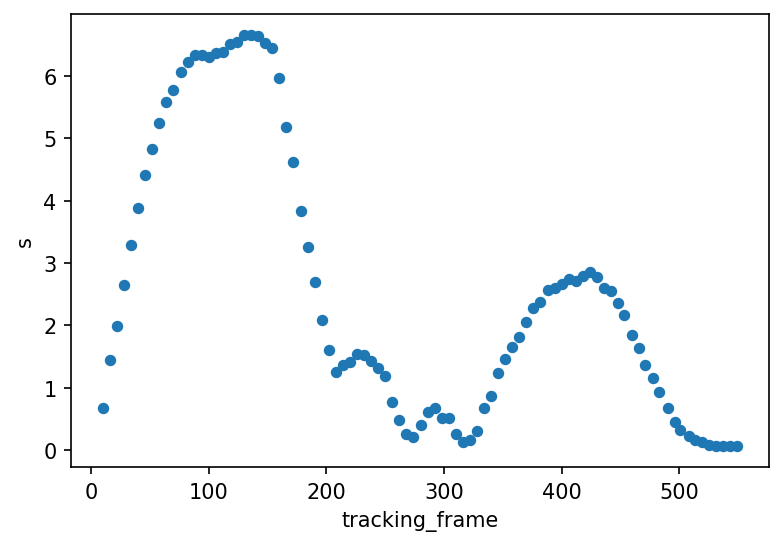

In [55]:
train_tracking.query("video_id=='57583_000082' and player=='H46'").plot(x='tracking_frame', y='s', kind='scatter')

# Prepare data for learning

only frames with 22 players

In [37]:
counts = train_labels[['video', 'frame', 'label']].groupby(['video', 'frame']).count().reset_index()

In [38]:
frames22 = counts[counts['label'] == 22][['video', 'frame']]

In [39]:
train_labels22 = train_labels.merge(frames22, on=['video', 'frame'])

In [40]:
len(train_labels)

983884

In [41]:
len(train_labels22)

187000

In [42]:
train_labels22

,gameKey,playID,view,video,frame,label,left,width,top,height,impact,impactType,confidence,visibility,video_id
0,57583,82,Sideline,57583_000082_Sideline.mp4,1,H30,956,15,357,13,NaN,NaN,NaN,NaN,57583_000082
1,57583,82,Sideline,57583_000082_Sideline.mp4,1,V72,450,13,306,12,NaN,NaN,NaN,NaN,57583_000082
2,57583,82,Sideline,57583_000082_Sideline.mp4,1,V74,401,11,373,13,NaN,NaN,NaN,NaN,57583_000082
3,57583,82,Sideline,57583_000082_Sideline.mp4,1,V86,352,14,388,15,NaN,NaN,NaN,NaN,57583_000082
4,57583,82,Sideline,57583_000082_Sideline.mp4,1,V87,343,14,408,13,NaN,NaN,NaN,NaN,57583_000082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186995,58107,4362,Sideline,58107_004362_Sideline.mp4,191,V47,756,18,284,20,NaN,NaN,NaN,NaN,58107_004362
186996,58107,4362,Sideline,58107_004362_Sideline.mp4,191,H88,547,20,318,20,NaN,NaN,NaN,NaN,58107_004362
186997,58107,4362,Sideline,58107_004362_Sideline.mp4,191,V41,781,19,276,20,NaN,NaN,NaN,NaN,58107_004362
186998,58107,4362,Sideline,58107_004362_Sideline.mp4,191,V97,644,19,304,18,NaN,NaN,NaN,NaN,58107_004362


In [43]:
train_tracking

,gameKey,playID,player,time,x,y,s,a,dis,o,dir,event,video_id,video_start,tracking_frame
3234,57583,82,H97,2018-09-14T00:24:00.200Z,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3235,57583,82,H96,2018-09-14T00:24:00.200Z,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3236,57583,82,H90,2018-09-14T00:24:00.200Z,35.40,31.27,0.01,0.01,0.00,283.00,217.26,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3237,57583,82,H27,2018-09-14T00:24:00.200Z,39.77,17.57,1.32,1.32,0.14,273.32,73.94,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
3238,57583,82,H36,2018-09-14T00:24:00.200Z,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap,57583_000082,2018-09-14T00:24:00.200Z,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333806,58107,4362,V94,2019-12-10T04:33:24.500Z,102.79,34.85,0.82,0.33,0.09,114.29,95.41,NaN,58107_004362,2019-12-10T04:33:10.799Z,831
333807,58107,4362,V23,2019-12-10T04:33:24.500Z,103.67,33.31,0.45,0.76,0.05,149.52,188.26,NaN,58107_004362,2019-12-10T04:33:10.799Z,831
333808,58107,4362,V97,2019-12-10T04:33:24.500Z,105.39,30.99,0.34,0.21,0.03,252.65,19.92,NaN,58107_004362,2019-12-10T04:33:10.799Z,831
333809,58107,4362,V24,2019-12-10T04:33:24.500Z,109.32,31.84,0.23,0.14,0.02,281.64,220.19,NaN,58107_004362,2019-12-10T04:33:10.799Z,831


In [116]:
data22 = train_labels22.merge(train_tracking, left_on = ['video_id', 'label', 'frame'], right_on = ['video_id', 'player','tracking_frame'])

In [117]:
data22.head()

,gameKey_x,playID_x,view,video,frame,label,left,width,top,height,...,x,y,s,a,dis,o,dir,event,video_start,tracking_frame
0,57583,82,Sideline,57583_000082_Sideline.mp4,10,H96,440,15,400,17,...,35.48,22.70,0.01,0.01,0.00,230.88,68.71,ball_snap,2018-09-14T00:24:00.200Z,10
1,57583,82,Sideline,57583_000082_Sideline.mp4,10,H99,467,12,339,11,...,35.32,26.25,0.00,0.00,0.00,272.45,317.96,ball_snap,2018-09-14T00:24:00.200Z,10
2,57583,82,Sideline,57583_000082_Sideline.mp4,10,H97,500,12,304,18,...,35.56,28.89,0.00,0.00,0.00,247.29,47.40,ball_snap,2018-09-14T00:24:00.200Z,10
3,57583,82,Sideline,57583_000082_Sideline.mp4,10,V73,419,13,353,12,...,33.74,25.36,0.00,0.00,0.00,120.32,47.44,ball_snap,2018-09-14T00:24:00.200Z,10
4,57583,82,Sideline,57583_000082_Sideline.mp4,10,H36,614,16,397,18,...,40.11,22.30,3.21,2.54,0.33,266.62,226.29,ball_snap,2018-09-14T00:24:00.200Z,10


In [118]:
data22['xbox'] = data22['left'] + data22['width']/2
data22['ybox'] = data22['top'] - data22['height']/2

In [119]:
data22.head()

,gameKey_x,playID_x,view,video,frame,label,left,width,top,height,...,s,a,dis,o,dir,event,video_start,tracking_frame,xbox,ybox
0,57583,82,Sideline,57583_000082_Sideline.mp4,10,H96,440,15,400,17,...,0.01,0.01,0.00,230.88,68.71,ball_snap,2018-09-14T00:24:00.200Z,10,447.5,391.5
1,57583,82,Sideline,57583_000082_Sideline.mp4,10,H99,467,12,339,11,...,0.00,0.00,0.00,272.45,317.96,ball_snap,2018-09-14T00:24:00.200Z,10,473.0,333.5
2,57583,82,Sideline,57583_000082_Sideline.mp4,10,H97,500,12,304,18,...,0.00,0.00,0.00,247.29,47.40,ball_snap,2018-09-14T00:24:00.200Z,10,506.0,295.0
3,57583,82,Sideline,57583_000082_Sideline.mp4,10,V73,419,13,353,12,...,0.00,0.00,0.00,120.32,47.44,ball_snap,2018-09-14T00:24:00.200Z,10,425.5,347.0
4,57583,82,Sideline,57583_000082_Sideline.mp4,10,H36,614,16,397,18,...,3.21,2.54,0.33,266.62,226.29,ball_snap,2018-09-14T00:24:00.200Z,10,622.0,388.0


In [120]:
data22.columns

Index(['gameKey_x', 'playID_x', 'view', 'video', 'frame', 'label', 'left',
       'width', 'top', 'height', 'impact', 'impactType', 'confidence',
       'visibility', 'video_id', 'gameKey_y', 'playID_y', 'player', 'time',
       'x', 'y', 's', 'a', 'dis', 'o', 'dir', 'event', 'video_start',
       'tracking_frame', 'xbox', 'ybox'],
      dtype='object')

In [121]:
data22 = data22[['frame', 'video', 'xbox', 'ybox', 'x', 'y', 'label']]

In [122]:
unique_frames = data22[['video', 'frame']].drop_duplicates().values

In [123]:
unique_frames[:100]

array([['57583_000082_Sideline.mp4', 10],
       ['57583_000082_Sideline.mp4', 16],
       ['57583_000082_Sideline.mp4', 22],
       ['57583_000082_Sideline.mp4', 28],
       ['57583_000082_Sideline.mp4', 34],
       ['57583_000082_Sideline.mp4', 40],
       ['57583_000082_Sideline.mp4', 46],
       ['57583_000082_Sideline.mp4', 52],
       ['57583_000082_Sideline.mp4', 58],
       ['57583_000082_Sideline.mp4', 64],
       ['57583_000082_Sideline.mp4', 70],
       ['57583_000082_Sideline.mp4', 76],
       ['57583_000082_Sideline.mp4', 82],
       ['57583_000082_Sideline.mp4', 94],
       ['57583_000082_Sideline.mp4', 112],
       ['57583_000082_Sideline.mp4', 178],
       ['57583_000082_Sideline.mp4', 184],
       ['57583_000082_Sideline.mp4', 190],
       ['57583_000082_Sideline.mp4', 196],
       ['57583_000082_Sideline.mp4', 268],
       ['57583_000082_Sideline.mp4', 292],
       ['57584_000336_Endzone.mp4', 364],
       ['57584_000336_Sideline.mp4', 10],
       ['57584_000336_Sidel

In [82]:
def idxs(data):
    return [int(d[-1]) for d in data]

In [129]:
for video, frame in unique_frames:
    if video == "57586_001934_Endzone.mp4":
        data = data22.query("video==@video and frame == @frame").reset_index()
        print(data.head())
        box_data = data[['xbox', 'ybox', 'index']].values
        track_data = data[['x', 'y', 'index']].values

        x_sorted_box_data = sorted(box_data, key= lambda x: x[0])
        y_sorted_box_data = sorted(box_data, key= lambda x: x[1])
        x_sorted_track_data = sorted(track_data, key= lambda x: x[0])
        y_sorted_track_data = sorted(track_data, key= lambda x: x[1])

        print(idxs(x_sorted_box_data))
        print(idxs(x_sorted_track_data))
        print(idxs(y_sorted_box_data))
        print(idxs(y_sorted_track_data))
        break

   index  frame                     video   xbox   ybox      x      y label
0   1880    220  57586_001934_Endzone.mp4  282.0  250.0  72.28  23.93   V71
1   1881    220  57586_001934_Endzone.mp4  222.5  241.5  72.10  23.34   V14
2   1882    220  57586_001934_Endzone.mp4   69.0   41.5  62.65  21.59   H38
3   1883    220  57586_001934_Endzone.mp4   23.0  105.5  65.48  21.06   V19
4   1884    220  57586_001934_Endzone.mp4  471.0  210.0  70.35  26.39   V82
[1883, 1882, 1881, 1890, 1880, 1899, 1884, 1898, 1889, 1888, 1892, 1894, 1897, 1895, 1896, 1901, 1886, 1900, 1891, 1885, 1893, 1887]
[1882, 1892, 1883, 1896, 1898, 1884, 1899, 1890, 1889, 1891, 1881, 1900, 1880, 1901, 1888, 1897, 1893, 1894, 1895, 1885, 1886, 1887]
[1882, 1892, 1883, 1884, 1898, 1899, 1890, 1889, 1881, 1880, 1891, 1896, 1901, 1900, 1888, 1893, 1885, 1886, 1897, 1894, 1895, 1887]
[1883, 1882, 1881, 1890, 1880, 1899, 1884, 1898, 1888, 1889, 1892, 1894, 1897, 1895, 1901, 1900, 1886, 1896, 1891, 1885, 1893, 1887]


In [128]:
data22.query("video=='57586_001934_Endzone.mp4' and frame == '220'")['label'].unique()

array(['V71', 'V14', 'H38', 'V19', 'V82', 'V69', 'V74', 'V8', 'V61',
       'V79', 'H21', 'V30', 'H29', 'H96', 'H76', 'H44', 'H52', 'H97',
       'H50', 'H53', 'H31', 'V33'], dtype=object)

In [559]:
len(df[df['view'] == 'Endzone'])

453293

In [555]:
len(df[(df['width'] <= 32)])

851464

In [561]:
len(df[(df['height'] <= 24) & (df['view'] == 'Endzone')])

164597